 # Skin Diasese detection test

In [29]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
tf.__version__

'2.10.0'

## Processing the training set

In [31]:
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     brightness_range=[0.9,1.1],
#     fill_mode='nearest'
# )
# training_set = train_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/train',
#     target_size=(128, 128),
#     batch_size=16,
#     class_mode='categorical',
# )

## Preprocessing the test set

In [32]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_set = test_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/test',
#     target_size=(128, 128),
#     batch_size=16,
#     class_mode='categorical',
# )

In [33]:

# Common parameters
BATCH_SIZE   = 32
IMG_SIZE     = (224, 224)
DATA_DIR     = r"C:\Users\User\Downloads\Skin-disease-dataset\train"
SEED         = 42           # keeps split reproducible
VAL_SPLIT    = 0.20         # 80 % train, 20 % validation

datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=VAL_SPLIT      # ← **key line**
)



training_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',              # ← **80 % of images**
    shuffle=True,
    seed=SEED
)

test_set = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',            # ← **20 % of images**
    shuffle=True,
    seed=SEED
)


Found 38751 images belonging to 6 classes.
Found 9683 images belonging to 6 classes.


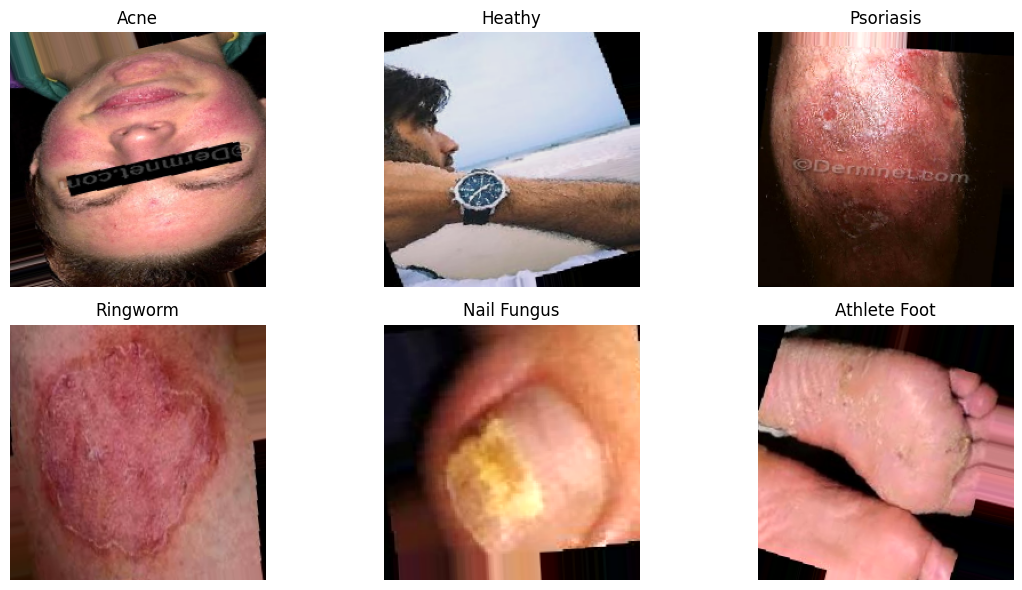

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load class indices (label → index mapping)
class_indices = training_set.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Create a map to store one image per class
seen_classes = set()
images = []
labels = []

# Iterate over batches to collect one image per class
for i in range(len(training_set)):
    x_batch, y_batch = training_set[i]
    for img, label in zip(x_batch, y_batch):
        class_index = np.argmax(label)
        if class_index not in seen_classes:
            seen_classes.add(class_index)
            images.append(img)
            labels.append(index_to_class[class_index])
        if len(seen_classes) == len(index_to_class):
            break
    if len(seen_classes) == len(index_to_class):
        break

# Plot the collected images
plt.figure(figsize=(12, 6))
for i in range(len(images)):
    plt.subplot(2, (len(images) + 1) // 2, i + 1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


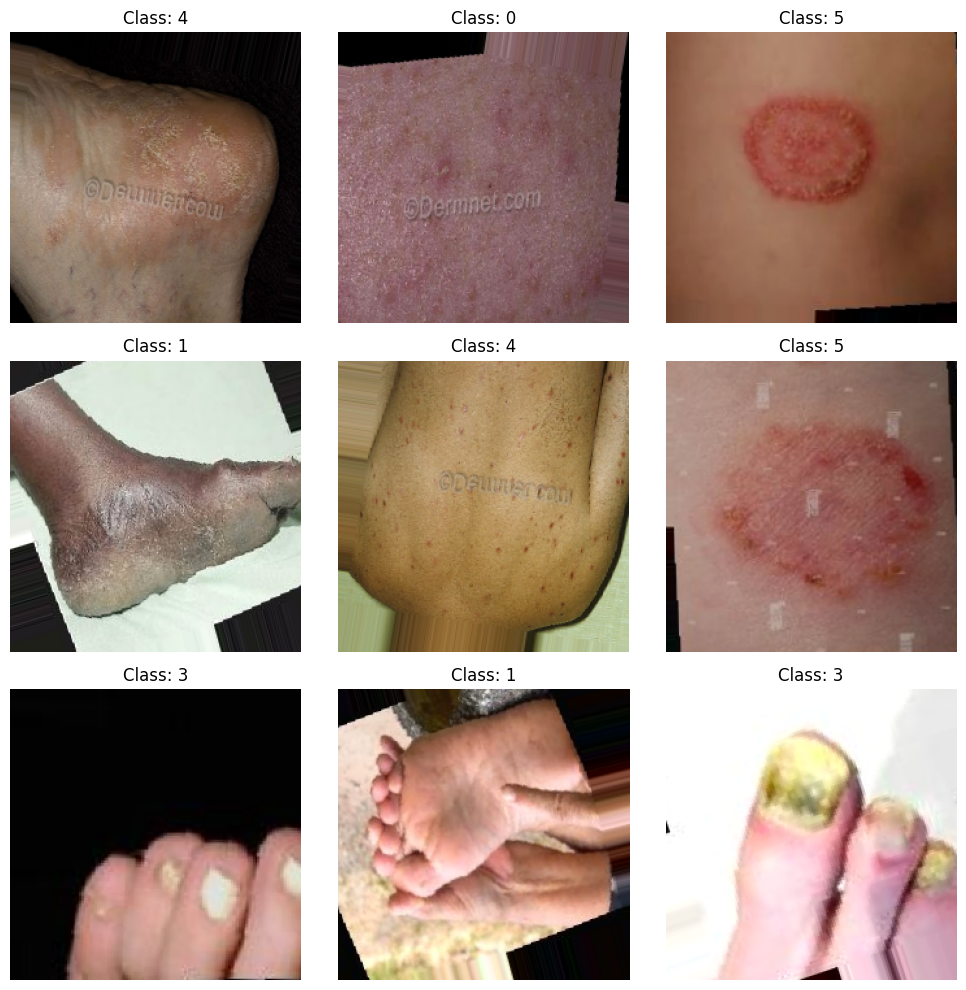

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from the training set
images, labels = next(training_set)

# Show 9 augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Building the CNN

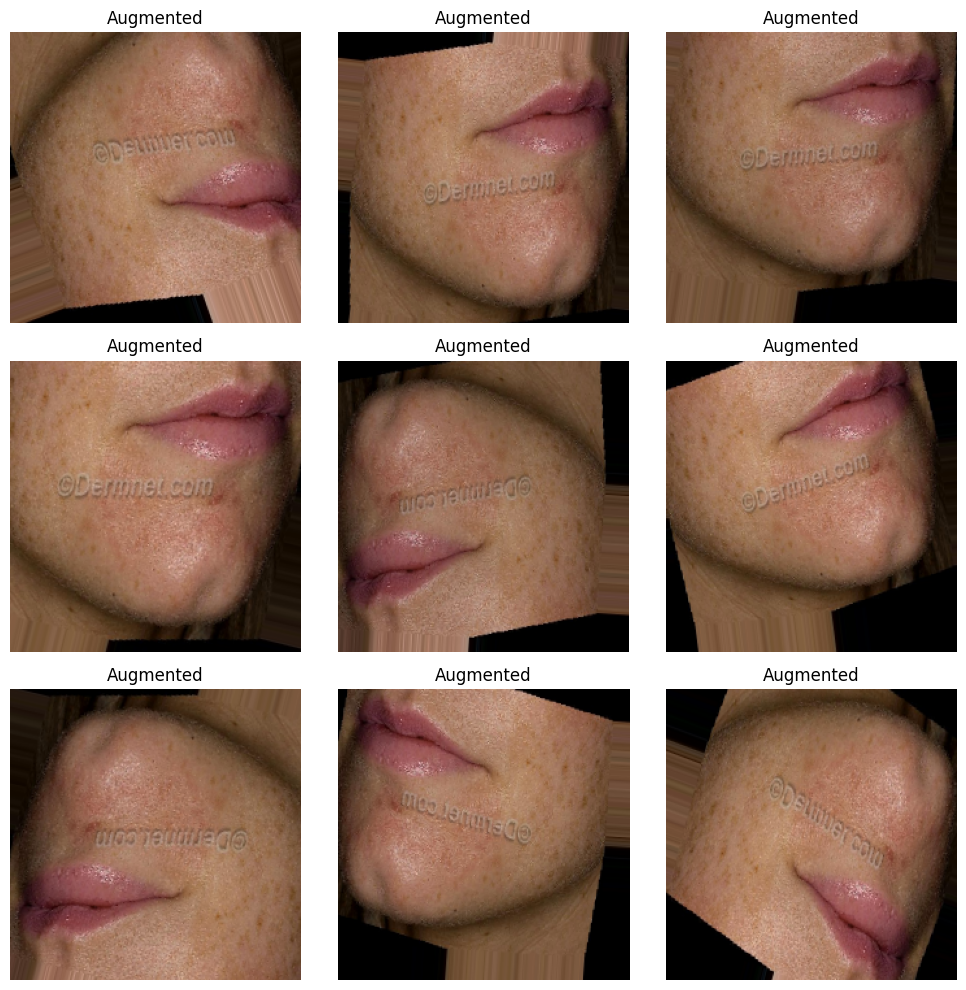

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Load a single image path
img_path = training_set.filepaths[0]
img = image.load_img(img_path, target_size=IMG_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Show multiple augmented versions
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented = datagen.flow(x, batch_size=1)
    aug_img = next(augmented)[0]  # single image in batch
    plt.subplot(3, 3, i + 1)
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [37]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint


# Load Pretrained MobileNetV2 (Exclude top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-40]: 
    layer.trainable = False



# Add Custom Classification Head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])




# Train Model
callbacks = [
    EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

#Stage 1: Train only classifier head
base_model.trainable = False
model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(training_set, validation_data=test_set, epochs=10)

# Stage 2: Fine-tune entire model
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(training_set, validation_data=test_set, epochs=20)


Epoch 1/10
1211/1211 [==============================] - 467s 383ms/step - loss: 0.3028 - accuracy: 0.8800 - val_loss: 0.1725 - val_accuracy: 0.9355
Epoch 2/10
1211/1211 [==============================] - 466s 385ms/step - loss: 0.1987 - accuracy: 0.9201 - val_loss: 0.1687 - val_accuracy: 0.9439
Epoch 3/10
1211/1211 [==============================] - 393s 325ms/step - loss: 0.1825 - accuracy: 0.9290 - val_loss: 0.1522 - val_accuracy: 0.9474
Epoch 4/10
1211/1211 [==============================] - 391s 322ms/step - loss: 0.1674 - accuracy: 0.9351 - val_loss: 0.1591 - val_accuracy: 0.9398
Epoch 5/10
1211/1211 [==============================] - 390s 322ms/step - loss: 0.1572 - accuracy: 0.9400 - val_loss: 0.1488 - val_accuracy: 0.9525
Epoch 6/10
1211/1211 [==============================] - 388s 320ms/step - loss: 0.1464 - accuracy: 0.9442 - val_loss: 0.1719 - val_accuracy: 0.9514
Epoch 7/10
1211/1211 [==============================] - 387s 320ms/step - loss: 0.1408 - accuracy: 0.9463 - val_

1/1 [==============================] - 1s 854ms/step


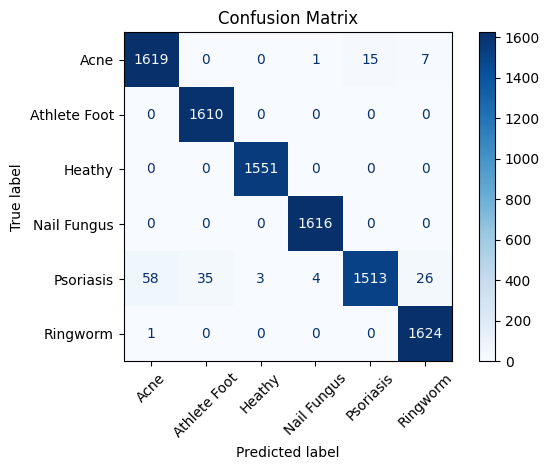

In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get true labels and predictions
Y_true = []
Y_pred = []

# Go through test batches and collect predictions
for i in range(len(test_set)):
    x_batch, y_batch = test_set[i]
    y_pred_batch = model.predict(x_batch)
    
    Y_true.extend(np.argmax(y_batch, axis=1))
    Y_pred.extend(np.argmax(y_pred_batch, axis=1))

    if (i + 1) * test_set.batch_size >= test_set.samples:
        break  # Stop if we've processed all test data

# 2. Compute confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
labels = list(test_set.class_indices.keys())  # Class names

# 3. Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [39]:
# eval_datagen = ImageDataGenerator(rescale=1./255)

# eval_set = eval_datagen.flow_from_directory(
#     'C:/Users/User/Downloads/6_skin_diseases/kaggle/val',
#     target_size=(128, 128),
#     batch_size=64,
#     class_mode='categorical',
#     shuffle=False  # Important: keep order for correct confusion matrix
# )
# import numpy as np
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# # Predict
# y_true = eval_set.classes
# y_pred_probs = model.predict(eval_set)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # Class names
# class_labels = list(eval_set.class_indices.keys())

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap='Blues', xticks_rotation=45)
# plt.title("Confusion Matrix on Custom Eval Folder")
# plt.tight_layout()
# plt.show()


In [40]:
model.save('299-model-test-v4.h5')

In [68]:
print(training_set.class_indices)

{'Acne': 0, 'Athlete Foot': 1, 'Heathy': 2, 'Nail Fungus': 3, 'Psoriasis': 4, 'Ringworm': 5}


In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array  # ✅ Modern import

# Load and preprocess the image
test_image = load_img('C:/Users/User/Downloads/Skin-disease-dataset/single-prediction/nf2.jpg', target_size=(224, 224))
test_image = img_to_array(test_image) / 255.0 
test_image = np.expand_dims(test_image, axis=0)


# Predict using the CNN model
result = model.predict(test_image)

# Define class labels in the same order as training_set.class_indices
# class_labels = [
#     "Acne",
#     "Athlete Foot",
#     "Heathy"
#     "Nail Fungus",
#     "Psoriasis",
#     "Rigworm"
# ]
class_labels = list(training_set.class_indices.keys())
# Get the predicted class index
predicted_index = np.argmax(result[0])
prediction = class_labels[predicted_index]
print("Probabilities:", result[0])
print("Predicted class:", prediction)

1/1 [==============================] - 0s 21ms/step
Probabilities: [2.7713114e-01 9.2144379e-05 2.5386607e-02 1.0856940e-06 6.9726378e-01
 1.2525408e-04]
Predicted class: Rigworm
